# CD8 Mapper Vignette

In this vignette we will show how to use the T-DeepInsight to map the GEX from the query dataset to the reference dataset. 

In [37]:
import gc
import umap
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

import tcr_deep_insight as tdi

## Load datasets
the reference (all genes) and query datasets

In [3]:
# load the data
luoma_raw_TIL = "./source/CD8Mapper_data/luoma_raw_TIL.h5ad"
luoma_raw_PBMC = "./source/CD8Mapper_data/luoma_raw_PBMC.h5ad"
watson_origin = "./source/CD8Mapper_data/waston_origin.h5ad"

In [4]:
adata_query = sc.concat([
    sc.read_h5ad(luoma_raw_TIL),
    sc.read_h5ad(luoma_raw_PBMC),
    sc.read_h5ad(watson_origin)
])

In [5]:
adata_ref = sc.read_h5ad('./source/CD8Mapper_data/adata_reference_genes.h5ad') # with all genes

In [6]:
adata_total = sc.concat([adata_ref,adata_query])

In [7]:
sc.pp.normalize_total(adata_total)
sc.pp.log1p(adata_total)
sc.pp.highly_variable_genes(adata_total, n_top_genes=5000)

In [8]:
adata_ref = adata_ref[:, adata_total.var[adata_total.var['highly_variable']].index]
adata_query = adata_query[:, adata_total.var[adata_total.var['highly_variable']].index]

In [15]:
gc.collect()

1521

## Retrain the model
with constrain_latent_embedding to the orignial

In [16]:
model = tdi.model.VAEModel(
    adata=adata_ref, 
    batch_key="sample_name", 
    device='cuda:1',
    constrain_latent_embedding=True
)

Sat Jun 24 16:42:20 2023	Initializing dataset into memory
Sat Jun 24 16:42:20 2023	warning: the provided n_batch=0 does not match the number of batch in the adata.
Sat Jun 24 16:42:20 2023	setting n_batch to 436


In [17]:
model.fit(max_epoch=32, lr=5e-5)

Epoch 32: 100%|██████████████████████| 32/32 [27:27<00:00, 51.48s/it, loss=1.99e+05, reconst=1.98e+05, kldiv=1.54e+03]


## Transfer adata_query to the reference adata

In [18]:
model.transfer(adata_query, 'sample_name')
model.adata = sc.concat([adata_ref, adata_query], join='outer')[:,adata_ref.var.index]

Sat Jun 24 17:14:27 2023	Initializing dataset into memory
Sat Jun 24 17:14:27 2023	warning: the provided n_batch=436 does not match the number of batch in the adata.
Sat Jun 24 17:14:27 2023	setting n_batch to 546


In [19]:
del adata_ref
gc.collect()

1726

In [20]:
model.initialize_dataset()

Sat Jun 24 17:15:24 2023	Initializing dataset into memory


In [21]:
Z = model.get_latent_embedding()
z = umap.UMAP(n_jobs=32).fit_transform(Z)
model.adata.obsm["X_umap"] = z
model.adata.obsm["X_pca"] = Z

In [22]:
model.adata.write_h5ad("./source/CD8Mapper_data/results/vae_transfer_watson_luoma.h5ad")

## Allocate subtype to the reference cells
also the reference or query identity of each cell

In [23]:
obs = pd.read_csv("./source/CD8Mapper_data/20221101_adata_nogex_obs.csv", index_col=0, low_memory=False)

In [24]:
adata = model.adata
adata.obs['type']='query'
adata.obs.loc[obs.index,'type'] = 'reference'
adata.obs.loc[obs.index,'cell_subtype'] = obs['cell_subtype']

## Annotate query cells via KNN

In [25]:
knnc = KNeighborsClassifier(n_neighbors=23, n_jobs=16)
knnc.fit(adata[adata.obs['type'] == 'reference'].obsm["X_pca"], 
         adata.obs.loc[adata.obs['type'] == 'reference', 'cell_subtype'])
adata.obs.loc[adata.obs['type'] != 'reference', 'cell_subtype'] =  knnc.predict(adata[adata.obs['type'] != 'reference'].obsm["X_pca"])

In [26]:
adata.write_h5ad("./source/CD8Mapper_data/results/annotated_vae_transfer_watson_luoma.h5ad") # save the result

## Plot the query cell subtypes

In [35]:
adata_query = adata[adata.obs['type']=='query']
adata.obs.loc[adata.obs['type']=='query', 'query_subtype'] = adata_query.obs['cell_subtype']

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


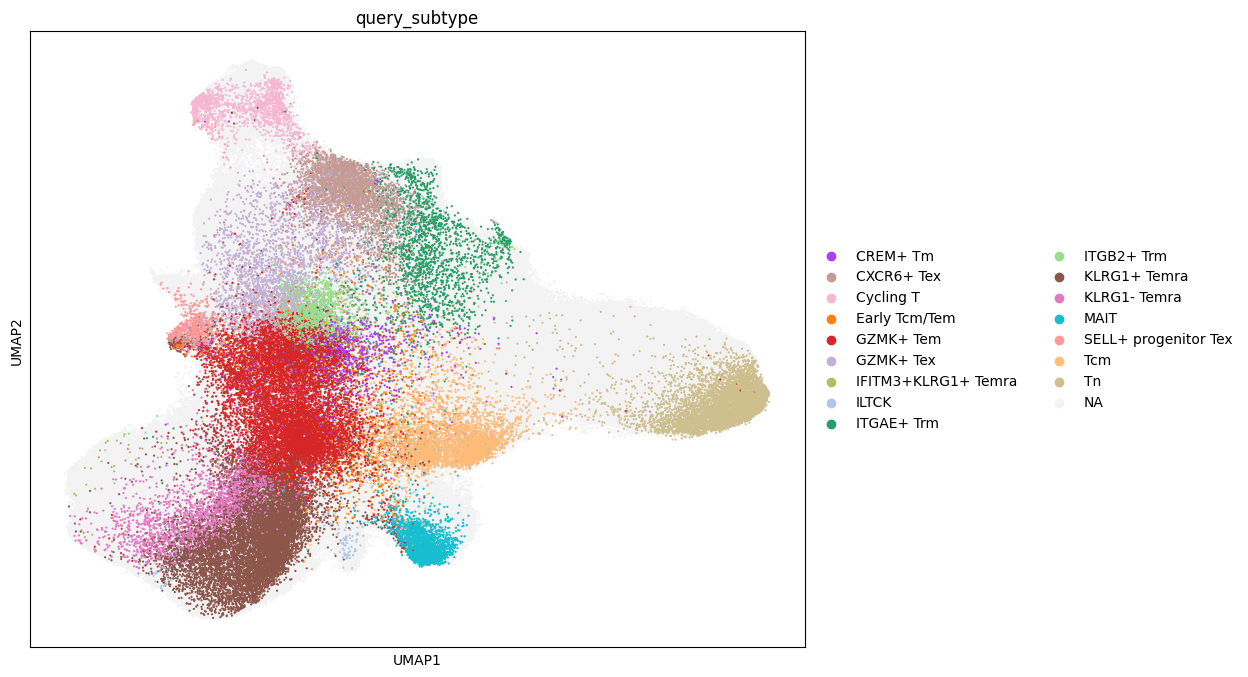

In [38]:
fig,ax=plt.subplots()
fig.set_size_inches(10,8)
subtype_color = {
    'Tn':'#CEBF8F',
    'Tcm':'#ffbb78',
    'Early Tcm/Tem':'#ff7f0e',
    'GZMK+ Tem':'#d62728',
    'CREM+ Tm':'#aa40fc',
    'KLRG1+ Temra':'#8c564b',
    'KLRG1- Temra':'#e377c2',
    'IFITM3+KLRG1+ Temra':'#b5bd61',
    'MAIT':'#17becf',
    'ILTCK':'#aec7e8',
    'ITGAE+ Trm':'#279e68',
    'ITGB2+ Trm':'#98df8a',
    'SELL+ progenitor Tex':'#ff9896',
    'GZMK+ Tex':'#c5b0d5',
    'CXCR6+ Tex':'#c49c94',
    'Cycling T':'#f7b6d2'
}
sc.pl.umap(adata, color=['query_subtype'], size=10, 
           palette=subtype_color,
           na_color='#F3F3F3', ax=ax)
fig.savefig("./figures/query_subtype.png",dpi=600)